In [ ]:
 from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls "/content/drive/Shared drives"

'Safety Critical System '	      'Software Testing and QA'
'security and dependability course '


In [ ]:
import os
base = "/content/drive/Shared drives/Safety Critical System /dataset"
print("Files in folder:")
for f in os.listdir(base):
    print(f)

Files in folder:
DoS_dataset.csv
Botnet-Friday-02-03-2018.csv
Bruteforce-Wednesday-14-02-2018.csv
DDoS1-Tuesday-20-02-2018.csv
DDoS2-Wednesday-21-02-2018.csv
DoS1-Thursday-15-02-2018.csv
DoS2-Friday-16-02-2018.csv
Infil1-Wednesday-28-02-2018.csv
Infil2-Thursday-01-03-2018.csv
Web1-Thursday-22-02-2018.csv
Web2-Friday-23-02-2018.csv


In [ ]:
!ls "/content/drive/Shared drives/Safety Critical System /dataset"

Botnet-Friday-02-03-2018.csv	     DoS_dataset.csv
Bruteforce-Wednesday-14-02-2018.csv  Infil1-Wednesday-28-02-2018.csv
DDoS1-Tuesday-20-02-2018.csv	     Infil2-Thursday-01-03-2018.csv
DDoS2-Wednesday-21-02-2018.csv	     Web1-Thursday-22-02-2018.csv
DoS1-Thursday-15-02-2018.csv	     Web2-Friday-23-02-2018.csv
DoS2-Friday-16-02-2018.csv


In [ ]:
import os
import pandas as pd

base = "/content/drive/Shared drives/Safety Critical System /dataset"
fname = "DoS1-Thursday-15-02-2018.csv"
path = os.path.join(base, fname)

df = pd.read_csv(path)            # add encoding='latin1' if you get an encoding error
print(df.shape)
df.head()

(1048575, 80)


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,15/02/2018 08:25:18,112641158,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320579.0,7.042784e+02,56321077,56320081,Benign
1,22,6,15/02/2018 08:29:05,37366762,14,12,2168,2993,712,0,...,32,1024353.0,649038.754495,1601183,321569,11431221.0,3.644991e+06,15617415,8960247,Benign
2,47514,6,15/02/2018 08:29:42,543,2,0,64,0,64,0,...,32,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
3,0,0,15/02/2018 08:28:07,112640703,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320351.5,3.669884e+02,56320611,56320092,Benign
4,0,0,15/02/2018 08:30:56,112640874,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320437.0,7.198347e+02,56320946,56319928,Benign


In [ ]:
# Install (some packages are preinstalled in Colab already)
!pip install -q scikit-learn pandas tqdm

# Imports
import os, time, math, json
from collections import Counter
import numpy as np, pandas as pd
from tqdm import tqdm
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
print("Torch", torch.__version__, "CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Torch 2.8.0+cu126 CUDA: False
Using device: cpu


In [ ]:
import numpy as np
import gc
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- CONFIGURATION FOR LSTM ---
# IMPORTANT: You must define a sequence length. This is how many previous
# network flows/rows the model will look at to predict the current flow.
SEQUENCE_LENGTH = 10
# ------------------------------

# Drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Identify label column
label_col = None
for c in df.columns:
    if c.lower() in ['label', 'attack', 'category', 'class']:
        label_col = c
        break
if label_col is None:
    raise ValueError("No label column found.")

# Separate features and labels
y = df[label_col].copy()
X = df.drop(label_col, axis=1)
del df
gc.collect()

# Encode categorical columns
cat_cols = X.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    # Note: Using .astype(str) handles potential mixed types or missing values robustly
    X[col] = le.fit_transform(X[col].astype(str))

# Replace NaNs/Infs
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Convert labels to binary (0: Benign, 1: Attack)
if y.dtype == 'O':
    y = y.apply(lambda x: 0 if x.lower() == 'benign' else 1)
y = y.astype(int)

# Normalize features (Crucial step before sequencing)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values.astype(np.float32))

# --- NEW CODE: CONVERT TABULAR DATA TO SEQUENCES FOR LSTM ---

def create_sequences(X, y, seq_length):
    """
    Transforms the scaled 2D data into 3D sequences for LSTM.
    Each sequence consists of 'seq_length' consecutive samples.
    The label corresponds to the last sample in the sequence.
    """
    X_seq, y_seq = [], []
    # We iterate until the last index that allows a full sequence of length 'seq_length'
    for i in range(len(X) - seq_length + 1):
        # Input sequence: samples from i up to i + seq_length
        X_seq.append(X[i:i + seq_length])
        # Output label: the label of the last sample in that sequence
        y_seq.append(y.iloc[i + seq_length - 1])

    # Return as NumPy arrays with the new shapes
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


# Apply the sequencing function
X_seq_np, y_seq_np = create_sequences(X_scaled, y, SEQUENCE_LENGTH)

print("Preprocessing complete!")
print(f"Features (3D Sequence Shape): {X_seq_np.shape}")
print(f"Labels (Reduced Shape): {y_seq_np.shape}")
print("Sample label distribution:", pd.Series(y_seq_np).value_counts().to_dict())

# Store the final NumPy arrays to be converted to PyTorch Tensors later
X_tensor_source = X_seq_np
y_tensor_source = y_seq_np

Preprocessing complete!
Features (3D Sequence Shape): (1048566, 10, 79)
Labels (Reduced Shape): (1048566,)
Sample label distribution: {0.0: 996068, 1.0: 52498}


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# NOTE: X_tensor_source and y_tensor_source were created as NumPy arrays
# in the data_preprocessing_lstm.py step.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- CRITICAL CHANGE: Use the sequence-ready NumPy arrays ---
# X_tensor_source is 3D (samples, seq_len, features)
X_tensor = torch.tensor(X_tensor_source, dtype=torch.float32)

# y_tensor_source is 1D (samples), needs to be 2D (samples, 1)
y_tensor = torch.tensor(y_tensor_source, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)

# The total length of the dataset is now len(X) - SEQUENCE_LENGTH + 1
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use PyTorch's random_split
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Note: Batch size should be a factor of the new, reduced dataset size
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)
test_loader = DataLoader(test_ds, batch_size=256)

print(f"Data split — Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Using device: cpu
Data split — Train: 733996, Val: 157284, Test: 157286


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# --- HYPERPARAMETERS FOR CNN-LSTM ---
# NOTE: input_dim is the number of features in a single flow (X_scaled.shape[1])
# We assume this variable is available from the preprocessing step.
INPUT_DIM = X_tensor_source.shape[2] # Number of features (channels for Conv1D)
SEQUENCE_LENGTH = X_tensor_source.shape[1] # Time steps (length for Conv1D)

# CNN Hyperparameters
CONV_OUT_CHANNELS = 64 # Number of filters/channels output by the CNN
KERNEL_SIZE = 3          # Size of the convolution window (e.g., look at 3 time steps)

# LSTM Hyperparameters
LSTM_INPUT_DIM = CONV_OUT_CHANNELS # Output of CNN becomes input to LSTM
HIDDEN_DIM = 128
NUM_LAYERS = 2
DROPOUT_RATE = 0.3
# ----------------------------------------------------

class CNN_LSTM_Net(nn.Module):
    """
    Hybrid CNN-LSTM network for sequence classification.
    CNN extracts local features, and LSTM learns temporal dependencies over those features.
    """
    def __init__(self, input_dim, seq_len, conv_out_channels, kernel_size, hidden_dim, num_layers, dropout_rate, num_classes=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # 1. CNN Block (Feature Extraction over time dimension)
        # Input shape expected: (Batch, Channels=INPUT_DIM, Length=SEQUENCE_LENGTH)
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=conv_out_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(conv_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2) # Downsample the sequence length
        )

        # Calculate the new sequence length after MaxPool1d
        # We assume MaxPool1d halves the length (simplified)
        self.new_seq_len = seq_len // 2

        # 2. LSTM Block (Temporal Dependency Learning)
        # Input to LSTM is (Batch, new_seq_len, conv_out_channels)
        self.lstm = nn.LSTM(
            conv_out_channels,        # The new feature dimension
            hidden_dim,
            num_layers,
            batch_first=True,         # Input is (batch, sequence_length, features)
            dropout=dropout_rate
        )

        # 3. Final Output Head (Classification)
        self.out_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
            # CRITICAL: Sigmoid is removed. Use nn.BCEWithLogitsLoss().
        )

    def forward(self, x):
        # x shape: (batch_size, SEQUENCE_LENGTH, INPUT_DIM)

        # --- CNN STEP 1: Permute for Conv1D ---
        # Change shape to (Batch, Channels=INPUT_DIM, Length=SEQUENCE_LENGTH)
        x = x.permute(0, 2, 1)

        # --- CNN STEP 2: Feature Extraction ---
        # x shape: (Batch, CONV_OUT_CHANNELS, NEW_SEQUENCE_LENGTH)
        x = self.conv(x)

        # --- LSTM STEP 1: Permute back for LSTM ---
        # Change shape to (Batch, Sequence_Length=NEW_SEQ_LEN, Features=CONV_OUT_CHANNELS)
        x = x.permute(0, 2, 1)

        # --- LSTM STEP 2: Temporal Learning ---
        # lstm_out: (batch, new_seq_len, hidden_dim)
        # h_n (final hidden state): (num_layers, batch, hidden_dim)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Extract the hidden state from the LAST layer (h_n[-1])
        # This state summarizes the entire sequence for the final prediction.
        final_h = h_n[-1] # shape: (batch_size, hidden_dim)

        # --- DENSE HEAD: Classification ---
        logits = self.out_head(final_h)

        return logits

# Instantiate the new CNN-LSTM model
model = CNN_LSTM_Net(
    input_dim=INPUT_DIM,
    seq_len=SEQUENCE_LENGTH,
    conv_out_channels=CONV_OUT_CHANNELS,
    kernel_size=KERNEL_SIZE,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout_rate=DROPOUT_RATE
).to(device)

print(f"CNN-LSTM Hybrid Model created. Input Dim: {INPUT_DIM}, Conv Channels: {CONV_OUT_CHANNELS}, LSTM Hidden Dim: {HIDDEN_DIM}")

CNN-LSTM Hybrid Model created. Input Dim: 79, Conv Channels: 64, LSTM Hidden Dim: 128


In [ ]:
import torch.nn as nn
import torch.optim as optim

# --- Import Hyperparameters and Model Class ---
# We assume the hyperparameters (INPUT_DIM, SEQUENCE_LENGTH, CONV_OUT_CHANNELS, etc.)
# and the CNN_LSTM_Net class are available from the previously run 'lstm_model.py'.

# --- Instantiate the CNN-LSTM Hybrid Model ---
# The model instantiation now uses the required sequential hyperparameters.
model = CNN_LSTM_Net(
    input_dim=INPUT_DIM,
    seq_len=SEQUENCE_LENGTH,
    conv_out_channels=CONV_OUT_CHANNELS,
    kernel_size=KERNEL_SIZE,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout_rate=DROPOUT_RATE
).to(device)

# --- CRITICAL CHANGE: Update Loss Function ---
# Since the CNN_LSTM_Net output does not have a Sigmoid layer, we must use
# BCEWithLogitsLoss for numerical stability.
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0007)

print(model)
print(f"Criterion changed to: {type(criterion).__name__}")


CNN_LSTM_Net(
  (conv): Sequential(
    (0): Conv1d(79, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (out_head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Criterion changed to: BCEWithLogitsLoss


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Note: 'criterion' and 'device' are assumed to be defined globally
# (criterion is nn.BCEWithLogitsLoss())

def fgsm_attack(model, X, y, epsilon):
    """
    Performs the Fast Gradient Sign Method (FGSM) attack.
    X, y are the batch of sequences and labels (3D input for X).
    """
    # Clone and detach the original input
    X_orig = X.clone().detach().to(device)
    X_adv = X_orig.clone()

    # Enable gradient tracking on the adversarial sample
    X_adv.requires_grad = True

    # Forward pass and loss calculation
    outputs = model(X_adv)
    loss = criterion(outputs, y)

    # Backpropagate to compute the gradient
    model.zero_grad()
    loss.backward()

    # Apply the perturbation: Add epsilon * sign(gradient)
    X_adv = X_adv + epsilon * X_adv.grad.sign()

    # CRITICAL: Constrain the perturbed sample (X_adv) to be within
    # the L-infinity ball centered at the original sample (X_orig).
    # This ensures |X_adv - X_orig| <= epsilon.
    perturb = torch.clamp(X_adv - X_orig, min=-epsilon, max=epsilon)
    X_adv = (X_orig + perturb).detach()

    # NOTE: The previous clamp to [0.0, 1.0] is removed because
    # StandardScaler data is unbounded (e.g., [-3, 3]).

    return X_adv

def pgd_attack(model, X, y, epsilon=0.1, alpha=0.01, iters=10):
    """
    Performs the Projected Gradient Descent (PGD) attack (iterative FGSM).
    """
    X_orig = X.clone().detach().to(device)

    # Initialize adversarial sample randomly within the epsilon ball
    X_adv = X_orig + torch.empty_like(X_orig).uniform_(-epsilon, epsilon).to(device)

    # Ensure initialization is constrained by the epsilon ball
    perturb = torch.clamp(X_adv - X_orig, min=-epsilon, max=epsilon)
    X_adv = X_orig + perturb

    # Start the iterative attack
    for _ in range(iters):
        X_adv = X_adv.detach()
        X_adv.requires_grad = True

        outputs = model(X_adv)
        loss = criterion(outputs, y)

        model.zero_grad()
        loss.backward()

        # PGD Step: Apply gradient sign scaled by alpha
        X_adv = X_adv + alpha * X_adv.grad.sign()

        # Projection Step: Project back to L-infinity ball around X_orig
        perturb = torch.clamp(X_adv - X_orig, min=-epsilon, max=epsilon)
        X_adv = X_orig + perturb

    return X_adv.detach()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import torch
import numpy as np

# Note: The following variables/functions are assumed to be defined globally:
# model, device, criterion (nn.BCEWithLogitsLoss), fgsm_attack, pgd_attack.

def get_metrics_from_arrays(labels, preds_binary, preds_proba):
    """Calculates a comprehensive set of metrics for binary classification."""
    # Ensure all inputs are numpy arrays
    labels = np.array(labels)
    preds_binary = np.array(preds_binary)
    preds_proba = np.array(preds_proba)

    # Calculate ROC AUC, handling ValueError if only one class is present
    try:
        roc_auc = roc_auc_score(labels, preds_proba)
    except ValueError:
        roc_auc = 0.5 # Default to 0.5 if only one class is present in the test batch

    return {
        "accuracy": accuracy_score(labels, preds_binary),
        "f1": f1_score(labels, preds_binary, zero_division=0),
        "precision": precision_score(labels, preds_binary, zero_division=0),
        "recall": recall_score(labels, preds_binary, zero_division=0),
        "roc_auc": roc_auc
    }


def evaluate_clean(model, dataloader):
    """Evaluates the model on clean (unperturbed) data."""
    model.eval()
    all_preds_binary, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)

            # Forward pass
            logits = model(xb)
            probs = torch.sigmoid(logits)

            # Convert probabilities to binary predictions
            preds_binary = (probs > 0.5).int()

            # Collect results
            all_probs.extend(probs.cpu().numpy().reshape(-1))
            all_preds_binary.extend(preds_binary.cpu().numpy().reshape(-1))
            all_labels.extend(yb.cpu().numpy().reshape(-1))

    return get_metrics_from_arrays(all_labels, all_preds_binary, all_probs)


def evaluate_fgsm(model, dataloader, epsilon):
    """Evaluates the model under FGSM attack."""
    model.eval()
    all_preds_binary, all_labels, all_probs = [], [], []

    # Loop over batches (no torch.no_grad() here, as attack needs gradients)
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)

        # 1. Generate adversarial examples
        # fgsm_attack handles the required gradient step
        xb_adv = fgsm_attack(model, xb, yb, epsilon)

        # 2. Evaluate model on adversarial examples (use no_grad for evaluation)
        with torch.no_grad():
            logits = model(xb_adv)
            probs = torch.sigmoid(logits)
            preds_binary = (probs > 0.5).int()

            all_probs.extend(probs.cpu().numpy().reshape(-1))
            all_preds_binary.extend(preds_binary.cpu().numpy().reshape(-1))
            all_labels.extend(yb.cpu().numpy().reshape(-1))

    return get_metrics_from_arrays(all_labels, all_preds_binary, all_probs)


def evaluate_pgd(model, dataloader, epsilon, alpha, iters):
    """Evaluates the model under PGD attack."""
    model.eval()
    all_preds_binary, all_labels, all_probs = [], [], []

    # Loop over batches (no torch.no_grad() here, as attack needs gradients)
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)

        # 1. Generate adversarial examples
        # pgd_attack handles the required iterative gradient steps
        xb_adv = pgd_attack(model, xb, yb, epsilon, alpha, iters)

        # 2. Evaluate model on adversarial examples (use no_grad for evaluation)
        with torch.no_grad():
            logits = model(xb_adv)
            probs = torch.sigmoid(logits)
            preds_binary = (probs > 0.5).int()

            all_probs.extend(probs.cpu().numpy().reshape(-1))
            all_preds_binary.extend(preds_binary.cpu().numpy().reshape(-1))
            all_labels.extend(yb.cpu().numpy().reshape(-1))

    return get_metrics_from_arrays(all_labels, all_preds_binary, all_probs)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Note: 'model', 'optimizer', 'criterion', 'device', and 'fgsm_attack'
# are assumed to be defined globally.

def train_one_epoch_adv(model, dataloader, optimizer, criterion, epsilon=0.05):
    """
    Performs one epoch of training using Adversarial Training (AT).
    AT uses a combination of clean loss and adversarial loss (FGSM).
    """
    model.train()
    total_loss = 0

    # Iterate over the 3D sequence batches
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()

        # 1. Calculate Clean Loss
        logits_clean = model(xb)
        loss_clean = criterion(logits_clean, yb)

        # 2. Generate Adversarial Example (FGSM)
        # The fgsm_attack uses the current state of the model to generate the perturbation.
        xb_adv = fgsm_attack(model, xb, yb, epsilon)

        # 3. Calculate Adversarial Loss
        # Ensure the model is evaluated on the newly generated adversarial sample.
        logits_adv = model(xb_adv)
        loss_adv = criterion(logits_adv, yb)

        # 4. Combined Loss (Weighting clean and adversarial components)
        # This trains the model to be robust against both clean and perturbed data.
        loss = 0.5 * loss_clean + 0.5 * loss_adv

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss (scaled by batch size)
        total_loss += loss.item() * xb.size(0)

    # Return average loss per sample across the entire epoch
    return total_loss / len(dataloader.dataset)

In [ ]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Note: model, train_loader, test_loader, optimizer, criterion, device,
# fgsm_attack, evaluate_clean, evaluate_fgsm, and evaluate_pgd are assumed
# to be defined from previous cells.

epochs = 10      # 10 epochs
epsilon_train = 0.05 # Epsilon used for training FGSM attack

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    num_samples = 0

    # Training Loop
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        num_samples += xb.size(0)

        optimizer.zero_grad()

        # 1. Clean loss
        logits_clean = model(xb)
        loss_clean = criterion(logits_clean, yb)

        # 2. Adversarial loss (FGSM)
        # We ensure the attack functions correctly use the 3D sequential input
        xb_adv = fgsm_attack(model, xb, yb, epsilon_train)
        logits_adv = model(xb_adv)
        loss_adv = criterion(logits_adv, yb)

        # 3. Combined loss
        loss = 0.5 * loss_clean + 0.5 * loss_adv

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / num_samples

    # Evaluation after epoch (Model is implicitly set to .eval() inside the functions)

    # CRITICAL CHANGE: Store the full metrics dictionary
    metrics_clean = evaluate_clean(model, test_loader)
    metrics_fgsm = evaluate_fgsm(model, test_loader, epsilon=epsilon_train)
    metrics_pgd = evaluate_pgd(model, test_loader, epsilon=0.05, alpha=0.01, iters=5)

    # Print summary of results (Accessing 'accuracy' from the dictionary)
    print(f"\n--- Epoch {epoch} Results ---")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Clean Acc: {metrics_clean['accuracy']:.4f} | FGSM Acc: {metrics_fgsm['accuracy']:.4f} | PGD Acc: {metrics_pgd['accuracy']:.4f}")

    # Print additional metrics for detailed robustness analysis
    print("\n[ Clean Metrics ]")
    print(f"  F1: {metrics_clean['f1']:.4f} | Precision: {metrics_clean['precision']:.4f} | Recall: {metrics_clean['recall']:.4f} | AUC: {metrics_clean['roc_auc']:.4f}")

    print("\n[ FGSM Metrics (Epsilon={epsilon_train}) ]")
    print(f"  F1: {metrics_fgsm['f1']:.4f} | Precision: {metrics_fgsm['precision']:.4f} | Recall: {metrics_fgsm['recall']:.4f} | AUC: {metrics_fgsm['roc_auc']:.4f}")

    print("\n[ PGD Metrics (Epsilon=0.05) ]")
    print(f"  F1: {metrics_pgd['f1']:.4f} | Precision: {metrics_pgd['precision']:.4f} | Recall: {metrics_pgd['recall']:.4f} | AUC: {metrics_pgd['roc_auc']:.4f}")


--- Epoch 1 Results ---
Loss: 0.0081
Clean Acc: 0.9999 | FGSM Acc: 0.9997 | PGD Acc: 0.9998

[ Clean Metrics ]
  F1: 0.9989 | Precision: 0.9982 | Recall: 0.9996 | AUC: 1.0000

[ FGSM Metrics (Epsilon={epsilon_train}) ]
  F1: 0.9973 | Precision: 0.9957 | Recall: 0.9990 | AUC: 1.0000

[ PGD Metrics (Epsilon=0.05) ]
  F1: 0.9981 | Precision: 0.9971 | Recall: 0.9991 | AUC: 1.0000



--- Epoch 2 Results ---
Loss: 0.0008
Clean Acc: 0.9999 | FGSM Acc: 0.9998 | PGD Acc: 0.9998

[ Clean Metrics ]
  F1: 0.9987 | Precision: 0.9994 | Recall: 0.9980 | AUC: 1.0000

[ FGSM Metrics (Epsilon={epsilon_train}) ]
  F1: 0.9975 | Precision: 0.9994 | Recall: 0.9957 | AUC: 1.0000

[ PGD Metrics (Epsilon=0.05) ]
  F1: 0.9980 | Precision: 0.9994 | Recall: 0.9967 | AUC: 1.0000



--- Epoch 3 Results ---
Loss: 0.0006
Clean Acc: 0.9999 | FGSM Acc: 0.9999 | PGD Acc: 0.9999

[ Clean Metrics ]
  F1: 0.9993 | Precision: 0.9992 | Recall: 0.9994 | AUC: 1.0000

[ FGSM Metrics (Epsilon={epsilon_train}) ]
  F1: 0.9987 | Precision: 0.9991 | Recall: 0.9983 | AUC: 1.0000

[ PGD Metrics (Epsilon=0.05) ]
  F1: 0.9989 | Precision: 0.9991 | Recall: 0.9987 | AUC: 1.0000



--- Epoch 4 Results ---
Loss: 0.0005
Clean Acc: 0.9999 | FGSM Acc: 0.9999 | PGD Acc: 0.9999

[ Clean Metrics ]
  F1: 0.9994 | Precision: 0.9991 | Recall: 0.9996 | AUC: 1.0000

[ FGSM Metrics (Epsilon={epsilon_train}) ]
  F1: 0.9989 | Precision: 0.9990 | Recall: 0.9988 | AUC: 1.0000

[ PGD Metrics (Epsilon=0.05) ]
  F1: 0.9992 | Precision: 0.9991 | Recall: 0.9994 | AUC: 1.0000



--- Epoch 5 Results ---
Loss: 0.0003
Clean Acc: 0.9999 | FGSM Acc: 0.9998 | PGD Acc: 0.9999

[ Clean Metrics ]
  F1: 0.9994 | Precision: 0.9987 | Recall: 1.0000 | AUC: 1.0000

[ FGSM Metrics (Epsilon={epsilon_train}) ]
  F1: 0.9983 | Precision: 0.9971 | Recall: 0.9995 | AUC: 1.0000

[ PGD Metrics (Epsilon=0.05) ]
  F1: 0.9987 | Precision: 0.9978 | Recall: 0.9996 | AUC: 1.0000



--- Epoch 6 Results ---
Loss: 0.0003
Clean Acc: 0.9999 | FGSM Acc: 0.9999 | PGD Acc: 0.9999

[ Clean Metrics ]
  F1: 0.9994 | Precision: 0.9992 | Recall: 0.9996 | AUC: 1.0000

[ FGSM Metrics (Epsilon={epsilon_train}) ]
  F1: 0.9992 | Precision: 0.9991 | Recall: 0.9992 | AUC: 1.0000

[ PGD Metrics (Epsilon=0.05) ]
  F1: 0.9992 | Precision: 0.9992 | Recall: 0.9992 | AUC: 1.0000



--- Epoch 7 Results ---
Loss: 0.0002
Clean Acc: 0.9999 | FGSM Acc: 0.9999 | PGD Acc: 0.9999

[ Clean Metrics ]
  F1: 0.9995 | Precision: 0.9990 | Recall: 1.0000 | AUC: 1.0000

[ FGSM Metrics (Epsilon={epsilon_train}) ]
  F1: 0.9992 | Precision: 0.9985 | Recall: 0.9999 | AUC: 1.0000

[ PGD Metrics (Epsilon=0.05) ]
  F1: 0.9994 | Precision: 0.9989 | Recall: 0.9999 | AUC: 1.0000



--- Epoch 8 Results ---
Loss: 0.0002
Clean Acc: 0.9999 | FGSM Acc: 0.9999 | PGD Acc: 0.9999

[ Clean Metrics ]
  F1: 0.9995 | Precision: 0.9991 | Recall: 0.9999 | AUC: 1.0000

[ FGSM Metrics (Epsilon={epsilon_train}) ]
  F1: 0.9992 | Precision: 0.9990 | Recall: 0.9994 | AUC: 1.0000

[ PGD Metrics (Epsilon=0.05) ]
  F1: 0.9993 | Precision: 0.9991 | Recall: 0.9995 | AUC: 1.0000



--- Epoch 9 Results ---
Loss: 0.0002
Clean Acc: 0.9999 | FGSM Acc: 0.9999 | PGD Acc: 0.9999

[ Clean Metrics ]
  F1: 0.9995 | Precision: 0.9990 | Recall: 1.0000 | AUC: 1.0000

[ FGSM Metrics (Epsilon={epsilon_train}) ]
  F1: 0.9992 | Precision: 0.9983 | Recall: 1.0000 | AUC: 1.0000

[ PGD Metrics (Epsilon=0.05) ]
  F1: 0.9994 | Precision: 0.9987 | Recall: 1.0000 | AUC: 1.0000



--- Epoch 10 Results ---
Loss: 0.0002
Clean Acc: 0.9999 | FGSM Acc: 0.9999 | PGD Acc: 0.9999

[ Clean Metrics ]
  F1: 0.9994 | Precision: 0.9989 | Recall: 1.0000 | AUC: 1.0000

[ FGSM Metrics (Epsilon={epsilon_train}) ]
  F1: 0.9992 | Precision: 0.9985 | Recall: 1.0000 | AUC: 1.0000

[ PGD Metrics (Epsilon=0.05) ]
  F1: 0.9992 | Precision: 0.9985 | Recall: 1.0000 | AUC: 1.0000


<>:129: SyntaxWarning: invalid escape sequence '\e'
<>:130: SyntaxWarning: invalid escape sequence '\e'
<>:129: SyntaxWarning: invalid escape sequence '\e'
<>:130: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-2389413872.py:129: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Robustness Curve: Accuracy vs. Attack Intensity ($\epsilon$)', fontsize=14)
/tmp/ipython-input-2389413872.py:130: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Epsilon ($\epsilon$) - Attack Strength', fontsize=12)




--- Generating Robustness Curve (Sweeping Epsilon) ---
Evaluating FGSM...


Evaluating PGD...


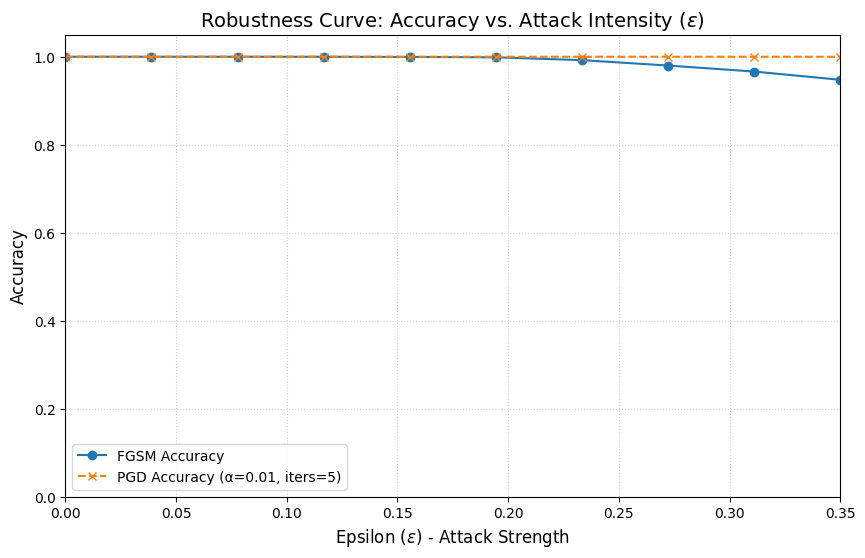


Robustness Curve Plot Displayed.

✅ Final Model Evaluation:
Clean Acc: 1.0000 | F1: 0.9996
FGSM Attack (ε=0.05) Acc: 0.9999 | F1: 0.9994
PGD Attack (ε=0.05) Acc: 0.9999 | F1: 0.9994


In [ ]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Note: model, train_loader, test_loader, optimizer, criterion, device,
# fgsm_attack, evaluate_clean, evaluate_fgsm, and evaluate_pgd are assumed
# to be defined from previous cells.

# Re-define train_one_epoch_adv here to ensure it is runnable, though
# it should already be defined in training_loop.py
# def train_one_epoch_adv(model, dataloader, optimizer, criterion, epsilon=0.05):
#     """
#     Performs one epoch of training using Adversarial Training (AT).
#     (Copied from training_loop.py for self-contained execution)
#     """
#     model.train()
#     total_loss = 0
#     for xb, yb in dataloader:
#         xb, yb = xb.to(device), yb.to(device)
#         optimizer.zero_grad()
#         logits_clean = model(xb)
#         loss_clean = criterion(logits_clean, yb)

#         # Ensure fgsm_attack is defined and available (assumed from attack_functions.py)
#         # Note: This requires fgsm_attack to be globally available or imported.
#         xb_adv = fgsm_attack(model, xb, yb, epsilon)
#         logits_adv = model(xb_adv)
#         loss_adv = criterion(logits_adv, yb)

#         loss = 0.5 * loss_clean + 0.5 * loss_adv
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * xb.size(0)
#     return total_loss / len(dataloader.dataset)


# --- MAIN TRAINING AND EVALUATION LOOP ---

# epochs = 10      # 10 epochs
# epsilon_train = 0.05 # Epsilon used for training FGSM attack

# print("Starting Adversarial Training...")
# for epoch in range(1, epochs + 1):
#     model.train()
#     total_loss = 0
#     num_samples = 0

#     # Training Loop using the defined function
#     for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False):
#         xb, yb = xb.to(device), yb.to(device)
#         num_samples += xb.size(0)

#         optimizer.zero_grad()

#         # 1. Clean loss
#         logits_clean = model(xb)
#         loss_clean = criterion(logits_clean, yb)

#         # 2. Adversarial loss (FGSM)
#         xb_adv = fgsm_attack(model, xb, yb, epsilon_train)
#         logits_adv = model(xb_adv)
#         loss_adv = criterion(logits_adv, yb)

#         # 3. Combined loss
#         loss = 0.5 * loss_clean + 0.5 * loss_adv

#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * xb.size(0)

#     avg_loss = total_loss / num_samples

    # Evaluation after epoch
    # metrics_clean = evaluate_clean(model, test_loader)
    # metrics_fgsm = evaluate_fgsm(model, test_loader, epsilon=epsilon_train)
    # metrics_pgd = evaluate_pgd(model, test_loader, epsilon=0.05, alpha=0.01, iters=5)

    # print(f"\n--- Epoch {epoch} Results ---")
    # print(f"Loss: {avg_loss:.4f}")
    # print(f"Clean Acc: {metrics_clean['accuracy']:.4f} | FGSM Acc: {metrics_fgsm['accuracy']:.4f} | PGD Acc: {metrics_pgd['accuracy']:.4f}")

    # print("\n[ Clean Metrics ]")
    # print(f"  F1: {metrics_clean['f1']:.4f} | Precision: {metrics_clean['precision']:.4f} | Recall: {metrics_clean['recall']:.4f} | AUC: {metrics_clean['roc_auc']:.4f}")

    # print("\n[ FGSM Metrics (Epsilon={epsilon_train}) ]")
    # print(f"  F1: {metrics_fgsm['f1']:.4f} | Precision: {metrics_fgsm['precision']:.4f} | Recall: {metrics_fgsm['recall']:.4f} | AUC: {metrics_fgsm['roc_auc']:.4f}")

    # print("\n[ PGD Metrics (Epsilon=0.05) ]")
    # print(f"  F1: {metrics_pgd['f1']:.4f} | Precision: {metrics_pgd['precision']:.4f} | Recall: {metrics_pgd['recall']:.4f} | AUC: {metrics_pgd['roc_auc']:.4f}")

# --- ROBUSTNESS CURVE GENERATION ---

print("\n\n--- Generating Robustness Curve (Sweeping Epsilon) ---")

# 1. Define the range of attack intensities (Epsilons)
epsilons_to_test = np.linspace(0.0, 0.35, num=10).round(4).tolist()

fgsm_accuracies = []
pgd_accuracies = []

# 2. Sweep through the epsilon values for FGSM
print("Evaluating FGSM...")
for eps in tqdm(epsilons_to_test, desc="FGSM Sweep", leave=False):
    # evaluate_fgsm returns a dictionary, we extract the accuracy
    metrics = evaluate_fgsm(model, test_loader, epsilon=eps)
    fgsm_accuracies.append(metrics['accuracy'])

# 3. Sweep through the epsilon values for PGD
print("Evaluating PGD...")
alpha_pgd = 0.01
iters_pgd = 5
for eps in tqdm(epsilons_to_test, desc="PGD Sweep", leave=False):
    # evaluate_pgd returns a dictionary, we extract the accuracy
    metrics = evaluate_pgd(model, test_loader, epsilon=eps, alpha=alpha_pgd, iters=iters_pgd)
    pgd_accuracies.append(metrics['accuracy'])

# 4. Plot the Robustness Curve
plt.figure(figsize=(10, 6))

# Plot FGSM results
plt.plot(epsilons_to_test, fgsm_accuracies, marker='o', linestyle='-', label='FGSM Accuracy')

# Plot PGD results
plt.plot(epsilons_to_test, pgd_accuracies, marker='x', linestyle='--', label=f'PGD Accuracy (α={alpha_pgd}, iters={iters_pgd})')

plt.title('Robustness Curve: Accuracy vs. Attack Intensity ($\epsilon$)', fontsize=14)
plt.xlabel('Epsilon ($\epsilon$) - Attack Strength', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.xlim([0, max(epsilons_to_test)])
plt.ylim([0.0, 1.05])
plt.show()

print("\nRobustness Curve Plot Displayed.")

# --- Single Evaluation Example (Verification) ---
results_clean = evaluate_clean(model, test_loader)
results_fgsm = evaluate_fgsm(model, test_loader, epsilon=0.05)
results_pgd = evaluate_pgd(model, test_loader, epsilon=0.05, alpha=0.01, iters=5)

print("\n✅ Final Model Evaluation:")
print(f"Clean Acc: {results_clean['accuracy']:.4f} | F1: {results_clean['f1']:.4f}")
print(f"FGSM Attack (ε=0.05) Acc: {results_fgsm['accuracy']:.4f} | F1: {results_fgsm['f1']:.4f}")
print(f"PGD Attack (ε=0.05) Acc: {results_pgd['accuracy']:.4f} | F1: {results_pgd['f1']:.4f}")

In [ ]:
# import matplotlib.pyplot as plt

# eps_list = [0.01, 0.05, 0.1, 0.2]
# fgsm_results = [evaluate_fgsm(model, test_loader, eps) for eps in eps_list]

# plt.figure(figsize=(6,4))
# plt.plot(eps_list, fgsm_results, marker='o')
# plt.title("FGSM Attack Impact on Model Accuracy")
# plt.xlabel("Epsilon (ε)")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.show()



In [ ]:
import torch

# Save the state dictionary of the adversarially trained CNN-LSTM model
# The file name reflects the model type (CNN-LSTM), application (IDS),
# and training method (adv_trained).
torch.save(model.state_dict(), "cnn_lstm_ids_adv_trained.pth")
print("Model state dictionary saved successfully to cnn_lstm_ids_adv_trained.pth")


Model state dictionary saved successfully to cnn_lstm_ids_adv_trained.pth
